In [1]:
import numpy as np
import pandas as pd
from glob import glob

from matplotlib import pyplot as plt

from parse_input_file import parse_file
from create_feature_dfs import compose_signals_df, create_initial_input, create_df_only_outs

from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera

from ARMA import ARMA
from metrics import akkake_criteria, rmse, determination_coef, rsse, adjusted_det_coef, log_likelihood, mean_dependent_var, std_dependent_var, shwarz_criteria   

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
features_df_dorbin = create_df_only_outs('data/example_for_DW.txt')
features_df_time_series = create_df_only_outs('data/rts1.txt')

In [3]:
feature_df = pd.DataFrame({'x_'+str(i):create_df_only_outs(el) for i, el in enumerate(glob('data/RTS*'))})

feature_df['y'] = create_df_only_outs('data/rts1.txt')

In [4]:
feature_df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,y
0,374.12,786.31,363.97,408.62,288.90,465.29,322.85,2296.56
1,376.17,788.79,368.81,409.33,289.56,463.22,322.59,2306.87
2,380.34,792.27,369.50,413.30,289.20,463.92,324.09,2313.90
3,382.76,796.21,376.52,414.34,293.30,465.09,328.12,2339.79
4,386.37,793.43,376.05,417.96,291.39,468.23,328.72,2330.87


# Dorbin Watson statistic

In [5]:
print("Durbin Watsons statistic: {}".format(durbin_watson(features_df_dorbin)))

Durbin Watsons statistic: 1.2288100804239723


# Time Series stats

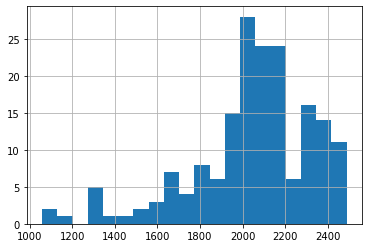

In [6]:
features_df_time_series.hist(bins=20)

In [7]:
pd.Series(data=[features_df_time_series.mean(),
                 features_df_time_series.median(),
                 features_df_time_series.max(),
                 features_df_time_series.min(),
                 features_df_time_series.std(),
                 features_df_time_series.skew(),
                 features_df_time_series.kurtosis(),
                 jarque_bera(features_df_time_series)[0],
                 jarque_bera(features_df_time_series)[1]],
          index=['mean',
                 'median',
                 'max',
                 'min',
                 'std',
                 'skewness',
                 'kurtosis',
                 'jarque_bera',
                 'jarque_bera_prob'])

mean                2.043537e+03
median              2.068170e+03
max                 2.487920e+03
min                 1.058840e+03
std                 2.899214e+02
skewness           -1.082895e+00
kurtosis            1.442272e+00
jarque_bera         4.809477e+01
jarque_bera_prob    3.600420e-11
dtype: float64

# ARMA

In [41]:
def get_complete_stats(y_true, y_pred, model_params):
    print(pd.Series({
                     'akaike': akkake_criteria(y_true, y_pred, model_params),
                     'rmse': rmse(y_true, y_pred, model_params),
                     'durbin watson':durbin_watson(y_true-y_pred),
                     'determination coef':determination_coef(y_true, y_pred),
                     'schwarz criteria': shwarz_criteria(y_true, y_pred, model_params),
                     'rsse': rsse(y_true, y_pred),
                     'adjusted det coef': adjusted_det_coef(y_true, y_pred, model_params),
                     'log likelihood': log_likelihood(y_true, y_pred),
                     'mean dependent var': mean_dependent_var(y_true, y_pred),
                     'std dependent var': std_dependent_var(y_true, y_pred)
                    }))

In [9]:
def get_stats(y_true, y_pred, model_params):
    print(pd.Series({
        'akaike': akkake_criteria(y_true, y_pred, model_params),
        'rmse': rmse(y_true, y_pred, model_params),
        'durbin watson':durbin_watson(y_true-y_pred),
        'determination coef':determination_coef(y_true, y_pred)
    }))

In [11]:
arma_ma_simple_5 = ARMA(on_residuals=True)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                10.293534
rmse                  41.232796
durbin watson          1.742176
determination coef     0.978219
dtype: float64


In [12]:
arma_ma_simple_5.arma_coefs

[50.35456463009518, 0.9729176620684906, 1]

In [13]:
pred, target = arma_ma_simple_5.ar_results

get_stats(target, pred, len(arma_ma_simple_5.initial_lin_reg_coefs))

akaike                10.525471
rmse                  46.440853
durbin watson          1.632104
determination coef     0.974521
dtype: float64


In [14]:
arma_ma_simple_5.initial_lin_reg_coefs

[-14.23885537271076, 1.0041926107395]

In [15]:
arma_ma_simple_5 = ARMA(on_residuals=True, ma_window_size=10)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                10.349241
rmse                  42.386670
durbin watson          1.667709
determination coef     0.978330
dtype: float64


In [16]:
arma_ma_simple_5.arma_coefs

[43.68643765020829, 0.9766064728004061, 1]

In [17]:
arma_ma_simple_5 = ARMA(on_residuals=True, ma_type='exp')
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                10.903322
rmse                  55.931504
durbin watson          1.659731
determination coef     0.983192
dtype: float64


In [18]:
arma_ma_simple_5.arma_coefs

[58.08944735417299, 0.9689546905227694, 1]

In [19]:
arma_ma_simple_5 = ARMA(on_residuals=True, ma_type='exp', ma_window_size=10)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                10.805391
rmse                  53.245265
durbin watson          1.585412
determination coef     0.985113
dtype: float64


In [20]:
arma_ma_simple_5.arma_coefs

[35.72554061254232, 0.98027735727919, 1]

In [21]:
arma_ma_simple_5 = ARMA(on_residuals=False)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                10.188492
rmse                  39.012508
durbin watson          1.550423
determination coef     0.975485
dtype: float64


In [22]:
arma_ma_simple_5.arma_coefs

[6.610079021112776, 0.6950011560255659, 1, -0.6999869515123424]

In [23]:
arma_ma_simple_5 = ARMA(on_residuals=False, ma_window_size=10)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                10.298158
rmse                  41.197582
durbin watson          1.591986
determination coef     0.977094
dtype: float64


In [24]:
arma_ma_simple_5.arma_coefs

[-6.0488838919705294, 0.8430218439927324, 1, -0.8413475029910644]

In [25]:
arma_ma_simple_5 = ARMA(on_residuals=False, ma_type='exp')
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                10.821821
rmse                  53.546319
durbin watson          1.520633
determination coef     0.979873
dtype: float64


In [26]:
arma_ma_simple_5.arma_coefs

[-3.209437475112292, 0.7694092732517194, 1, -0.7703875672955831]

In [27]:
arma_ma_simple_5 = ARMA(on_residuals=False, ma_type='exp', ma_window_size=10)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                10.781117
rmse                  52.449939
durbin watson          1.543327
determination coef     0.983885
dtype: float64


In [28]:
arma_ma_simple_5.arma_coefs

[-14.176484795382137, 0.9171922823615464, 1, -0.9118539167493523]

In [29]:
arma_ma_simple_5 = ARMA(on_residuals=False, use_own_ma_coefs=True)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                11.769978
rmse                  86.023944
durbin watson          0.400155
determination coef     0.950277
dtype: float64


In [30]:
arma_ma_simple_5.arma_coefs

[-317.4171705849278, -0.8580745989855552, 1, 1.0]

In [31]:
arma_ma_simple_5 = ARMA(on_residuals=False, ma_window_size=10, use_own_ma_coefs=True)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                 12.529508
rmse                  125.719658
durbin watson           0.181011
determination coef      0.950632
dtype: float64


In [32]:
arma_ma_simple_5.arma_coefs

[-729.4276365414855, -0.6674670254241115, 1, 1.0]

In [33]:
arma_ma_simple_5 = ARMA(on_residuals=False, ma_type='exp', use_own_ma_coefs=True)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                 12.707668
rmse                  137.478937
durbin watson           0.288403
determination coef      0.949530
dtype: float64


In [34]:
arma_ma_simple_5.arma_coefs

[-575.1863039506036, -0.7415620926513266, 1, 1.0]

In [35]:
arma_ma_simple_5 = ARMA(on_residuals=False, ma_type='exp', ma_window_size=10, use_own_ma_coefs=True)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                 13.602095
rmse                  214.937683
durbin watson           0.101896
determination coef      0.949270
dtype: float64


In [36]:
arma_ma_simple_5.arma_coefs

[-1342.2004024532982, -0.3889713892038295, 1, 1.0]

## Best model

In [37]:
arma_ma_simple_5 = ARMA(on_residuals=False)
pred, target = arma_ma_simple_5.fit_predict(features_df_time_series)

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                10.188492
rmse                  39.012508
durbin watson          1.550423
determination coef     0.975485
dtype: float64


In [38]:
arma_ma_simple_5.arma_coefs

[6.610079021112776, 0.6950011560255659, 1, -0.6999869515123424]

In [42]:
get_complete_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike                1.018849e+01
rmse                  3.901251e+01
durbin watson         1.550423e+00
determination coef    9.754852e-01
schwarz criteria      1.026140e+01
rsse                  2.572139e+05
adjusted det coef     9.504184e-01
log likelihood       -8.773045e+02
mean dependent var   -3.969182e-13
std dependent var     3.867079e+01
dtype: float64


# Multiple regression

In [43]:
feature_df.corr()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,y
x_0,1.000000,0.960564,0.851709,0.897707,0.682340,0.929083,0.956929,0.848433
x_1,0.960564,1.000000,0.808881,0.828220,0.739310,0.878301,0.925300,0.879438
x_2,0.851709,0.808881,1.000000,0.944448,0.841226,0.697672,0.798230,0.928940
x_3,0.897707,0.828220,0.944448,1.000000,0.726153,0.794041,0.886036,0.859188
x_4,0.682340,0.739310,0.841226,0.726153,1.000000,0.412473,0.667557,0.961389
x_5,0.929083,0.878301,0.697672,0.794041,0.412473,1.000000,0.887168,0.638377
x_6,0.956929,0.925300,0.798230,0.886036,0.667557,0.887168,1.000000,0.822547
y,0.848433,0.879438,0.928940,0.859188,0.961389,0.638377,0.822547,1.000000


In [44]:
scaled_feature_df = StandardScaler().fit_transform(feature_df)
feature_df = pd.DataFrame(scaled_feature_df, columns=feature_df.columns)

In [45]:
linear_reg = LinearRegression()
linear_reg.fit(feature_df.drop(columns='y'), feature_df['y'])
pred = linear_reg.predict(feature_df.drop(columns='y'))

get_stats(feature_df['y'], pred, 7)

akaike               -4.314013
rmse                  0.027455
durbin watson         0.442306
determination coef    0.999276
dtype: float64


In [46]:
get_complete_stats(feature_df['y'], pred, 7)

akaike               -4.314013e+00
rmse                  2.745490e-02
durbin watson         4.423063e-01
determination coef    9.992759e-01
schwarz criteria     -4.188886e+00
rsse                  1.288949e-01
adjusted det coef     9.984927e-01
log likelihood        3.909471e+02
mean dependent var    2.416918e-17
std dependent var     2.698555e-02
dtype: float64


In [47]:
linear_reg.intercept_, linear_reg.coef_

(1.8865756838786204e-15,
 array([-0.02143043,  0.23927177,  0.24595714, -0.02124278,  0.56181227,
         0.00171584,  0.06758316]))

In [48]:
glob('data/RTS*')

['data/RTScr.txt',
 'data/RTSfn.txt',
 'data/RTSmm.txt',
 'data/RTSin.txt',
 'data/RTSog.txt',
 'data/RTSeu.txt',
 'data/RTStl.txt']

# Multiple ARMA

In [49]:
arma_ma_simple_5 = ARMA(on_residuals=True, ma_window_size=5)
pred, target = arma_ma_simple_5.fit_predict(feature_df['y'], feature_df.drop(columns='y'))

get_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike               -5.840592
rmse                  0.012453
durbin watson         1.952700
determination coef    0.999814
dtype: float64


In [50]:
get_complete_stats(target, pred, len(arma_ma_simple_5.arma_coefs))

akaike               -5.840592e+00
rmse                  1.245314e-02
durbin watson         1.952700e+00
determination coef    9.998139e-01
schwarz criteria     -5.530731e+00
rsse                  2.419259e-02
adjusted det coef     9.995871e-01
log likelihood        5.222112e+02
mean dependent var    2.185952e-17
std dependent var     1.185979e-02
dtype: float64


In [51]:
arma_ma_simple_5.arma_coefs

[0.0016913409892948157,
 0.6220552224769514,
 -0.047815760422687786,
 0.03683860241082243,
 0.2616393818374164,
 -0.16619952683089093,
 0.2185010218766878,
 -0.12851299435758862,
 1,
 -0.037348678648325556,
 0.027459830923241075,
 0.5983132723116314,
 -0.3887659575375027,
 0.03542260511393553,
 -0.036969694913973734,
 0.09124202240302476,
 -0.05879430898793012]